In [1]:
#  !pip install PyTDC
#  !pip install pysmiles
#  !pip install rdkit

In [2]:
from tdc.single_pred import Tox
import pandas as pd
from rdkit import Chem
import rdkit
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

data = Tox(name = 'AMES')
split = data.get_split()

Downloading...
100%|██████████| 344k/344k [00:00<00:00, 4.27MiB/s]
Loading...
Done!


In [3]:
train_df = pd.DataFrame(split['train'])
val_df = pd.DataFrame(split['valid'])
test_df = pd.DataFrame(split['test'])

# Data checking + getting features

In [4]:
# Checks if mutagenicity- "Y" value is 0 or 1. Otherwise, filter it out
train_df = train_df[train_df["Y"].isin([0, 1])]
val_df = val_df[val_df["Y"].isin([0, 1])]
test_df = test_df[test_df["Y"].isin([0, 1])]

In [22]:
def get_descriptor(dataset):
  data = []
  label = []

  for i in range(len(dataset)):
    smiles = dataset.loc[i, "Drug"]
    label.append(dataset.loc[i, "Y"])
    mol = Chem.MolFromSmiles(smiles)
    if mol: # checks for valid smile strings
        fpD1 = Descriptors.FpDensityMorgan1(mol)
        fpD2 = Descriptors.FpDensityMorgan2(mol)
        fpD3 = Descriptors.FpDensityMorgan3(mol)
        mw = Descriptors.ExactMolWt(mol)
        heavyAtom = Descriptors.HeavyAtomCount(mol)
        data.append([fpD1, fpD2, fpD3, mw, heavyAtom])

  columns = ['FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'ExactMolWt', "HeavyAtomCount"]
  descriptor_df = pd.DataFrame(data, columns=columns)
  descriptor_df['Label'] = label

  return descriptor_df

# Splitting code up into features and labels

In [23]:
print("Train:")
print(len(train_df[train_df["Y"] == 1]))
print(len(train_df[train_df["Y"] == 0]))
print("=========================================")
print("Test:")
print(len(test_df[test_df["Y"] == 1]))
print(len(test_df[test_df["Y"] == 0]))
print("=========================================")
print("Val:")
print(len(val_df[val_df["Y"] == 1]))
print(len(val_df[val_df["Y"] == 0]))

print("=========================================")
print("Total:")
print(len(train_df[train_df["Y"] == 1]) + len(test_df[test_df["Y"] == 1]) + len(val_df[val_df["Y"] == 1]))
print(len(train_df[train_df["Y"] == 0]) + len(test_df[test_df["Y"] == 0]) + len(val_df[val_df["Y"] == 0]))

Train:
2759
2335
Test:
798
658
Val:
417
311
Total:
3974
3304


In [24]:
descriptor_df_train = get_descriptor(train_df)
descriptor_df_val = get_descriptor(val_df)
descriptor_df_test = get_descriptor(test_df)

X_train, y_train = descriptor_df_train.drop(columns=['Label']), descriptor_df_train['Label']
X_val, y_val = descriptor_df_val.drop(columns=['Label']), descriptor_df_val['Label']
X_test, y_test = descriptor_df_test.drop(columns=['Label']), descriptor_df_test['Label']

In [51]:
descriptor_df_train.head(10)
# to print csv uncomment
# descriptor_df_train.to_csv('full_dataset.csv', index=False)

,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,ExactMolWt,HeavyAtomCount,Label
0,0.782609,1.434783,2.130435,301.110279,23,1
1,0.240000,0.520000,0.860000,646.116486,50,0
2,1.636364,2.272727,2.727273,157.059974,11,1
3,1.600000,2.300000,2.800000,138.017775,10,1
4,1.526316,2.263158,2.842105,264.122240,19,1
5,1.750000,2.333333,2.750000,173.043656,12,1
6,1.178571,1.857143,2.500000,406.154702,28,0
7,0.666667,0.888889,1.111111,126.065394,9,0
8,1.043478,1.826087,2.608696,307.095691,23,1
9,1.437500,2.187500,2.937500,234.082684,16,0


# Fit RFC

In [26]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [27]:
y_pred = rf_classifier.predict(X_test)
from sklearn.metrics import roc_auc_score

auc_test = roc_auc_score(y_test, y_pred)
auc_train = roc_auc_score(y_train, rf_classifier.predict(X_train))
auc_val = roc_auc_score(y_val, rf_classifier.predict(X_val))

print(f"Test AUC: {auc_test}")
print(f"Train AUC: {auc_train}")
print(f"Val AUC: {auc_val}")

Test AUC: 0.6668533034714446
Train AUC: 0.9840869632031591
Val AUC: 0.6547957775258895


In [28]:

importances = rf_classifier.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

            Feature  Importance
3        ExactMolWt    0.358664
2  FpDensityMorgan3    0.201189
0  FpDensityMorgan1    0.178862
1  FpDensityMorgan2    0.158070
4    HeavyAtomCount    0.103216


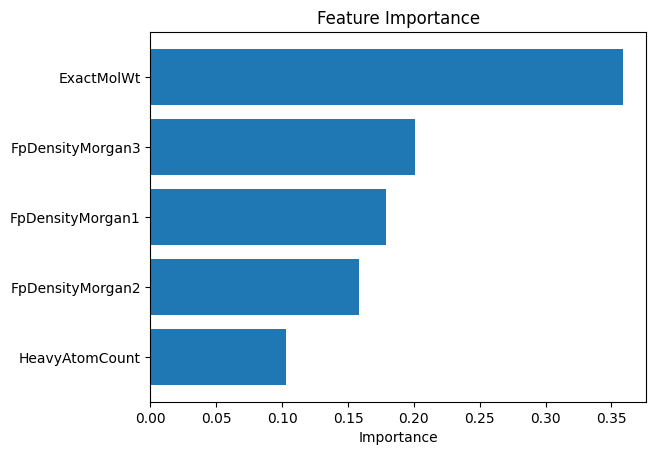

In [29]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# Fit kNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', p=1, n_jobs=-1)
kNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_jobs=-1, p=1, weights='distance')

In [35]:
y_pred = kNN.predict(X_test)
from sklearn.metrics import roc_auc_score

auc_test = roc_auc_score(y_test, kNN.predict(X_test))
auc_train = roc_auc_score(y_train, kNN.predict(X_train))
auc_val = roc_auc_score(y_val, kNN.predict(X_val))

print(f"Test AUC: {auc_test}")
print(f"Train AUC: {auc_train}")
print(f"Val AUC: {auc_val}")

Test AUC: 0.6585879592598518
Train AUC: 0.9855024591506247
Val AUC: 0.6580651877212057


In [45]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Calculate permutation importance for kNN
perm_importance = permutation_importance(kNN, X_train, y_train, scoring='roc_auc', n_repeats=30, random_state=42)

# Prepare a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': perm_importance.importances_mean  
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print(feature_importance_df)

            Feature  Importance
3        ExactMolWt    0.491246
4    HeavyAtomCount    0.288143
2  FpDensityMorgan3    0.057925
1  FpDensityMorgan2    0.033621
0  FpDensityMorgan1    0.029048


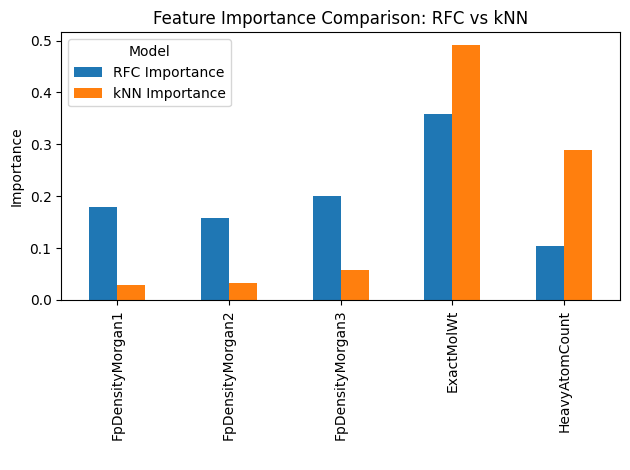

In [49]:
import matplotlib.pyplot as plt

# Assuming rf_classifier.feature_importances_ is calculated
rfc_importances = rf_classifier.feature_importances_

# Combine RFC and kNN feature importance into a DataFrame
feature_importance_comparison = pd.DataFrame({
    'Feature': X_train.columns,
    'RFC Importance': rfc_importances,
    'kNN Importance': perm_importance.importances_mean
})

# Plot the comparison
feature_importance_comparison.set_index('Feature').plot(kind='bar')
plt.title('Feature Importance Comparison: RFC vs kNN')
plt.ylabel('Importance')
plt.xlabel(' ')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [50]:
#uncomment to freeze requirements
# pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
